In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name='specific_seed_experiment'


## Specific Seed Experiment

In [3]:
seed= 1729        # 1729          
pyro_seed= 68     # 68      

import numpy as np
import torch
import pyro
import os

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(seed)
torch.manual_seed(seed)
pyro.set_rng_seed(pyro_seed)

### *Structural Causal Model*
$X_{4}=2\epsilon_{4}+1$
<br>
$X_{6}=\epsilon_{6}-1$
<br>
$X_{5}=3X_{6}+\epsilon_{5}-1$
<br>
$X_{2}=X_{5}-\epsilon_{2}$
<br>
$X_{3}=-3X_{4}+\epsilon_{3}-3$
<br>
$X_{1}=X_{6}-X_{5}+3\epsilon_{1}$
<br>
$Y=X_{1}+2X_{2}-3X_{3}+\epsilon_{Y}$

In [4]:
from config import sample_size
epsilon=np.random.normal(0,1,(sample_size,7))

In [5]:
def SCM(epsilon,intervention=False, *args):
    X_4=2*epsilon[:,4]+1
    X_6=epsilon[:,6]-1
    if not intervention:
        X_5=3*X_6+epsilon[:,5]-1
    else:
        X_5=np.full(sample_size,args)
    X_2=X_5-epsilon[:,2]
    X_3=-3*X_4+epsilon[:,3]-3
    X_1=X_6-X_5+3*epsilon[:,1]
    Y=X_1+2*X_2-3*X_3+epsilon[:,0]
    return X_6,X_5,X_4,X_3,X_2,X_1,Y

In [6]:
X_6,X_5,X_4,X_3,X_2,X_1,Y= SCM(epsilon,False)
Data={'X6':torch.tensor(X_6).reshape(-1,1).float(),'X5':torch.tensor(X_5).reshape(-1,1).float(),'X4':torch.tensor(X_4).reshape(-1,1).float(),'X3':torch.tensor(X_3).reshape(-1,1).float(),'X2':torch.tensor(X_2).reshape(-1,1).float(),'X1':torch.tensor(X_1).reshape(-1,1).float(),'Y':torch.tensor(Y).reshape(-1,1).float()}

In [ ]:
#from data import get_features_dataset 

In [ ]:
#get_features_dataset(data=Data,sample_size=sample_size,random_seed=seed)

In [7]:
from full_model import conditionalscm
scm=conditionalscm()

/home/saptarshi/anaconda3/envs/flow-scm/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [8]:
from partial_model import conditionalscm_partial
scm_partial=conditionalscm_partial()

In [9]:
from train import train_model 
#from config import save
logs=experiment_name+'/logs'
if not os.path.exists(logs):
        os.makedirs(logs)

In [10]:
train_model(scm,logs,seed=seed,data=Data,print_mode=True)

Epoch: 0 
Train set: Average LogProb: -171.930964


Test set: Average LogProb: -46.686749

Epoch: 100 
Train set: Average LogProb: -11.744967


Test set: Average LogProb: -11.755004

Epoch: 200 
Train set: Average LogProb: -11.732804


Test set: Average LogProb: -11.742023



In [10]:
train_model(scm_partial,logs,seed=seed,data=Data,print_mode=True)

Epoch: 0 
Train set: Average LogProb: -35.689421


Test set: Average LogProb: -12.973021

Epoch: 100 
Train set: Average LogProb: -5.378089


Test set: Average LogProb: -5.392345

Epoch: 200 
Train set: Average LogProb: -5.356988


Test set: Average LogProb: -5.390164

Epoch: 300 
Train set: Average LogProb: -5.354858


Test set: Average LogProb: -5.377345

Epoch: 400 
Train set: Average LogProb: -5.351629


Test set: Average LogProb: -5.365634

Epoch: 500 
Train set: Average LogProb: -5.349426


Test set: Average LogProb: -5.363352

Epoch: 600 
Train set: Average LogProb: -5.351357


Test set: Average LogProb: -5.377400

Epoch: 700 
Train set: Average LogProb: -5.348078


Test set: Average LogProb: -5.364767

Epoch: 800 
Train set: Average LogProb: -5.351113


Test set: Average LogProb: -5.383005

Epoch: 900 
Train set: Average LogProb: -5.350438


Test set: Average LogProb: -5.367177

==> Best LogProb: -5.362494, Time: 8.74 min



8.741983882586162

In [11]:
from infer import do_inference

In [12]:
j= 5
intervention='do(X5='+str(j)+')'
X6_cf,X5_cf, X4_cf, X3_cf, X2_cf, X1_cf, Y_cf= SCM(epsilon,True,j)

In [13]:
SCM_samples,SCM_inferred_noise,SCM_counterfactuals=do_inference(scm,intervention,data=Data,save=logs)
SCM_partial_samples,SCM_partial_inferred_noise,SCM_partial_counterfactuals=do_inference(scm_partial,intervention,data=Data,save=logs)

In [14]:
from analysis import error_estimate ,sampling_capabilities, noise_infer_capabilities

In [15]:
print('full model:', error_estimate(SCM_inferred_noise,epsilon))
print('\npartial model:', error_estimate(SCM_partial_inferred_noise,epsilon))

full model: {'X4 error': 1.320762470268288e-05, 'X6 error': 2.1691414074197818e-05, 'X5 error': 0.0003222385717188488, 'X3 error': 0.00037214870748754163, 'X2 error': 0.014082458709793499, 'X1 error': 0.0002505640417761604, 'Y error': 0.00047844779565659536}

partial model: {'X2 error': 0.014088917682052395, 'X1 error': 0.000315594889437939, 'Y error': 0.00044466696524917494}


In [16]:
path=+'assets/'
if not os.path.exists(path):
        os.makedirs(path)

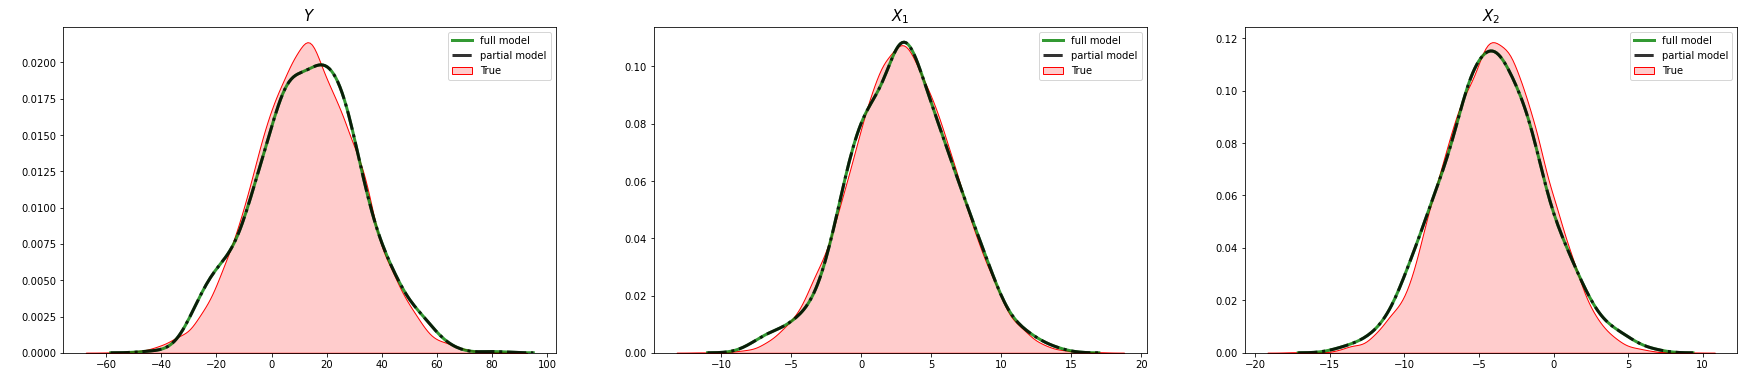

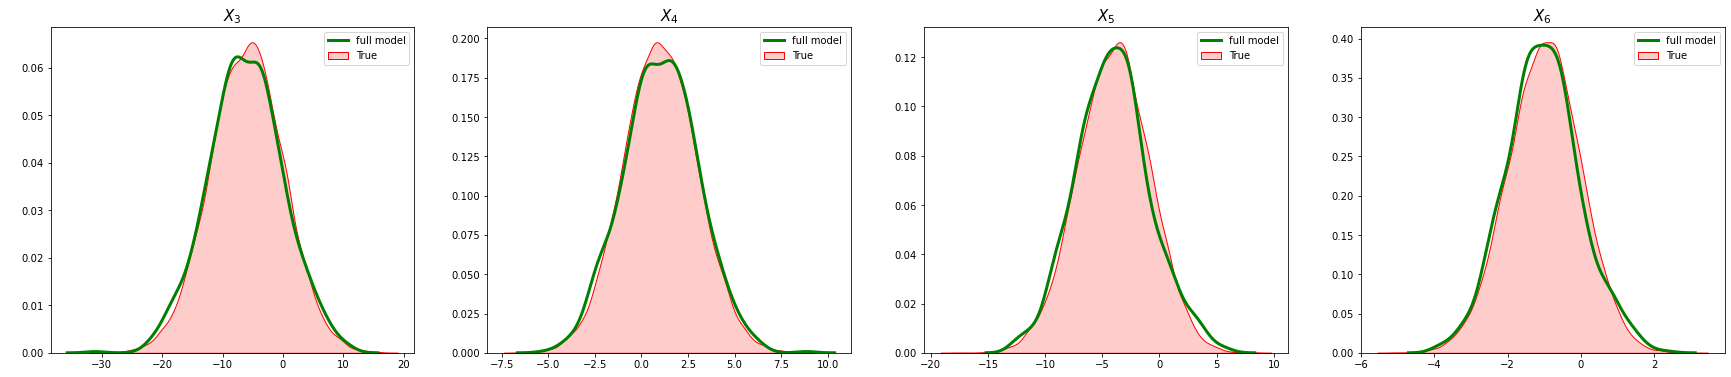

In [17]:
sampling_capabilities(Data=Data,SCM_samples=SCM_samples,SCM_partial_samples=SCM_samples,path=path)

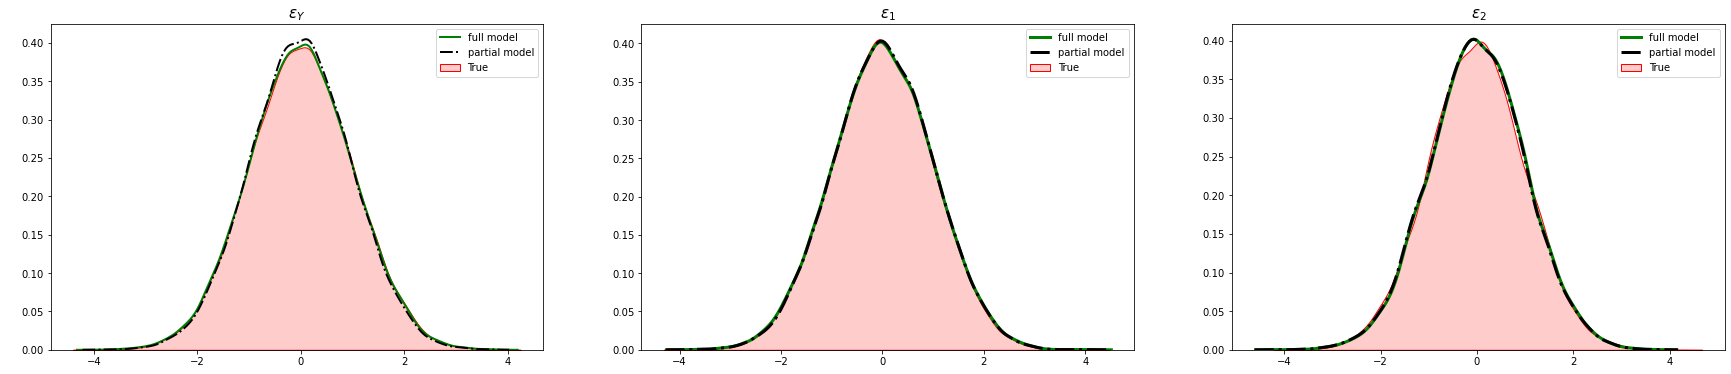

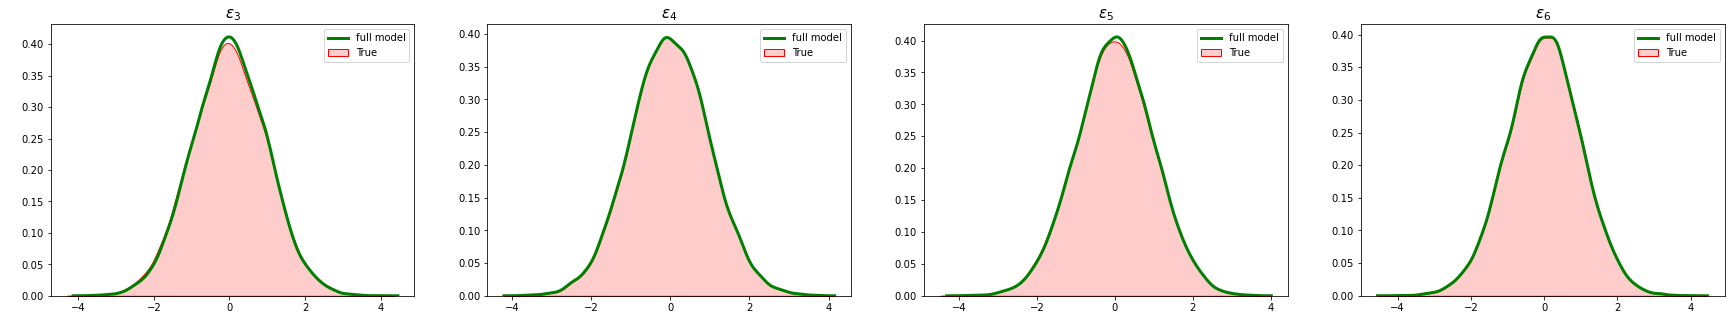

In [18]:
noise_infer_capabilities(epsilon=epsilon,SCM_partial_inferred_noise=SCM_partial_inferred_noise,SCM_inferred_noise=SCM_inferred_noise,path=path )

In [19]:
from analysis import plot_Y_cf

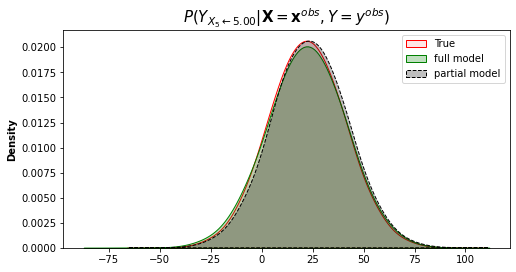

In [20]:
plot_Y_cf(Y_cf=Y_cf,j=j,SCM_partial_counterfactuals=SCM_partial_counterfactuals,SCM_counterfactuals=SCM_counterfactuals,path=path)

In [21]:
from cf_analysis import cf_analysis

In [22]:
np.random.seed(seed)
intervention_set=np.random.uniform(-30,30,200)

In [23]:
error_fullmodel,error_partialmodel=cf_analysis(intervention_set=intervention_set,data=Data,path=logs,SCM=SCM,scm=scm,scm_partial=scm_partial,epsilon=epsilon)

In [24]:
import pandas as pd
data=pd.DataFrame({'intervention':intervention_set,'error_partial':error_partialmodel,'error_full': error_fullmodel,'seed':1})
data

,intervention,error_partial,error_full,seed
0,-17.270484,0.010573,0.021480,1
1,-14.458906,0.009268,0.015645,1
2,-4.588687,0.002672,0.002662,1
3,13.179661,0.030020,0.107458,1
4,11.535056,0.026335,0.094149,1
...,...,...,...,...
195,29.711263,0.071403,0.161951,1
196,-3.429594,0.002289,0.002039,1
197,-3.816202,0.002416,0.002226,1
198,-4.362043,0.002614,0.002529,1


In [ ]:
#error_partialmodel=list(np.random.uniform(-1,1,5))
#error_fullmodel=list(np.random.uniform(-1,1,5))

In [ ]:
#data2=pd.DataFrame({'intervention':intervention_set,'error_partial':error_partialmodel,'error_full': error_fullmodel,'seed':2})
#data=data.append(data2,ignore_index=True)

In [ ]:
#data

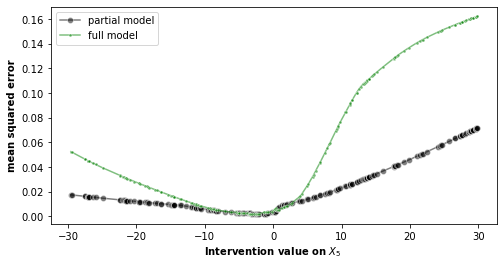

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns

#sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(8, 4))
#plt.scatter(intervention_set,np.exp(np.array(error_partial)),label='partial model',color='black',ls='-',marker='o')
#plt.scatter(intervention_set,np.exp(np.array(error_full)),label='full model',color='yellow',ls='--',marker='*')
sns.lineplot(data=data,x='intervention',y='error_partial',label='partial model',color='black',marker='o',alpha=0.5,ci='sd')
sns.lineplot(data=data,x='intervention',y='error_full',label='full model',color='green',marker='.',alpha=0.5,ci='sd')

plt.xlabel(r'Intervention value on $X_{5}$ ',fontweight='bold')
plt.ylabel('mean squared error',fontweight='bold')
plt.legend()
#fig.savefig('error_synthetic_data.pdf',format='pdf',pad_inches=0.1,bbox_inches='tight',dpi=1200)

## Results on unseen data from the SCM
We don't train the SCM with these daseed=89
np.random.seed(seed)
sample_size=20000
epsilon_unseen=np.random.normal(0,1,(sample_size,7))ta points ....we just do inference

In [ ]:
seed=89
np.random.seed(seed)
sample_size=20000
epsilon_unseen=np.random.normal(0,1,(sample_size,7))

In [ ]:
X_6,X_5,X_4,X_3,X_2,X_1,Y= SCM(epsilon_unseen,False)
Data={'X6':torch.tensor(X_6).reshape(-1,1).float(),'X5':torch.tensor(X_5).reshape(-1,1).float(),'X4':torch.tensor(X_4).reshape(-1,1).float(),'X3':torch.tensor(X_3).reshape(-1,1).float(),'X2':torch.tensor(X_2).reshape(-1,1).float(),'X1':torch.tensor(X_1).reshape(-1,1).float(),'Y':torch.tensor(Y).reshape(-1,1).float()}

In [ ]:
j= 1
intervention='do(X5='+str(j)+')'
X6_cf,X5_cf, X4_cf, X3_cf, X2_cf, X1_cf, Y_cf= SCM(epsilon_unseen,True,j)      #True Counterfactuals
#np.mean(Y)